# Gesture Recognition
In this group project, you are going to build a 3D Conv model that will be able to predict the 5 gestures correctly. Please import the following libraries to get started.

In [1]:
import numpy as np
import os
#from scipy.misc import imread, imresize
from skimage.io import imread
from skimage.util import crop
from skimage.transform import resize
import datetime
import os
import zipfile
import gdown
import matplotlib.pyplot as plt

We will download the data into a folder in Google Drive

In [2]:
url = 'https://drive.google.com/uc?id=1ehyrYBQ5rbQQe6yL4XbLWe3FMvuVUGiL'
output = 'data.zip'
gdown.download(url, output, quiet=False)

Downloading...
From: https://drive.google.com/uc?id=1ehyrYBQ5rbQQe6yL4XbLWe3FMvuVUGiL
To: /content/data.zip
100%|██████████| 1.71G/1.71G [00:06<00:00, 251MB/s]


'data.zip'

In [3]:
with zipfile.ZipFile("data.zip","r") as zip_ref:
    zip_ref.extractall("/content/dataDir")

os.listdir('/content/dataDir')

['Project_data']

In [4]:
os.listdir('/content/dataDir/Project_data')

['train', 'val.csv', 'train.csv', 'val']

In [5]:
# function to plot n images using subplots
def plot_image(images, captions=None, cmap=None, width = 50):
    f, axes = plt.subplots(1, len(images), sharey=True)
    f.set_figwidth(width)
    for ax,image in zip(axes, images):
        ax.imshow(image, cmap)

In [6]:
#Set Source path
source_path = '/content/dataDir/Project_data/'

We set the random seed so that the results don't vary drastically.

In [7]:
np.random.seed(30)
import random as rn
rn.seed(30)
from keras import backend as K
import tensorflow as tf
tf.random.set_seed(30)

In [45]:
train_doc = np.random.permutation(open(source_path+'train.csv').readlines())
val_doc = np.random.permutation(open(source_path+'val.csv').readlines())

# Add absolute path to file list
train_doc = np.array([source_path + 'train/' + x for x in train_doc])
val_doc = np.array([source_path + 'val/' + x for x in val_doc])

### Image Cropping and Resizing

Experimenting with what would be the most ideal way to get images in similar dimension

In [46]:
def get_folder_images (folder_dir):
  folder = folder_dir.strip().split(';')[0]
  imgs = os.listdir(folder) # read all the images in the folder
  # print(imgs)
  images = []
  for item in imgs: #  Iterate iver the frames/images of a folder to read them in
      # print(item)
      image = imread(folder +'/'+item).astype(np.float32)
      images.append(image)
  return images

In [47]:
# View some images randomly from each class

print(train_doc[0:7])
unique_class = train_doc[np.array([2, 0, 6, 1, 3])]
# print(unique_class)

imgs =get_folder_images(unique_class[0])
print(len(imgs))


['/content/dataDir/Project_data/train/WIN_20180907_16_32_11_Pro_Stop Gesture_new;Stop Gesture_new;2\n'
 '/content/dataDir/Project_data/train/WIN_20180925_17_27_40_Pro_Left_Swipe_new;Left_Swipe_new;0\n'
 '/content/dataDir/Project_data/train/WIN_20180925_17_28_04_Pro_Right_Swipe_new;Right_Swipe_new;1\n'
 '/content/dataDir/Project_data/train/WIN_20180907_16_07_46_Pro_Left Swipe_new_Left Swipe_new;Left Swipe_new_Left Swipe_new;0\n'
 '/content/dataDir/Project_data/train/WIN_20180925_17_37_42_Pro_Stop_new;Stop_new;2\n'
 '/content/dataDir/Project_data/train/WIN_20180907_15_53_12_Pro_Thumbs Up_new;Thumbs Up_new;4\n'
 '/content/dataDir/Project_data/train/WIN_20180926_17_42_43_Pro_Right_Swipe_new;Right_Swipe_new;1\n']
30


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

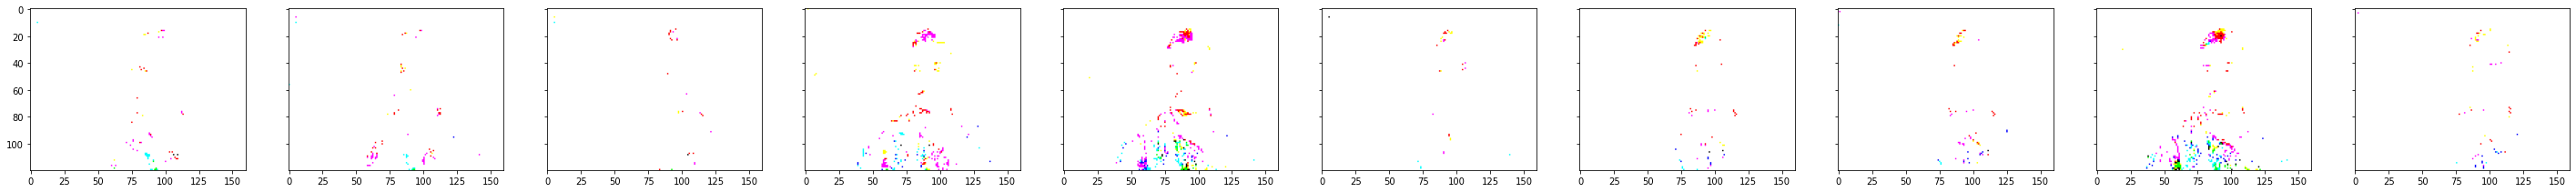

In [48]:
plot_image(imgs[0:10], cmap='gray')

Images without normalization seems to contain data that distorts the image, hence we will apply a standard normalization just to be able to have a proper view of the image

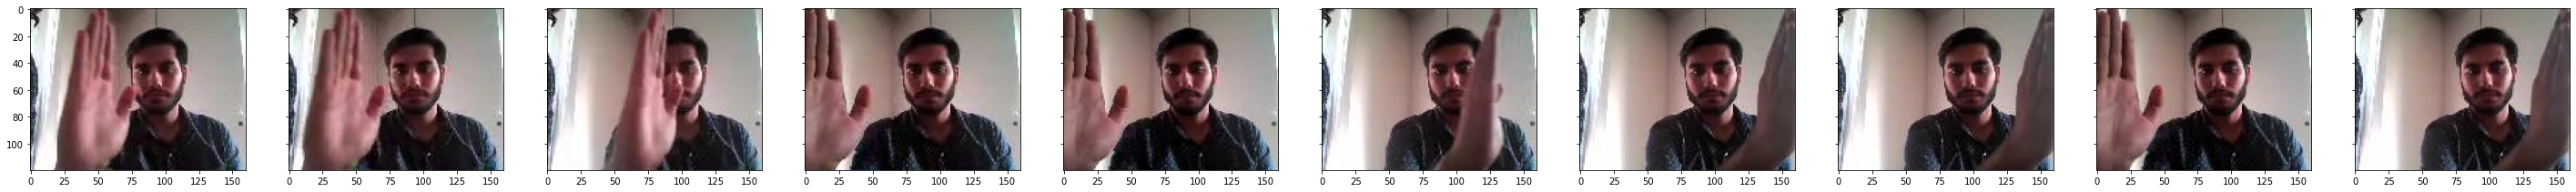

In [49]:
#adding standard normalization
imgs = [x/255 for x in imgs]
plot_image(imgs[0:10], cmap='gray')

We can crop 30 pixels from left and right and also up to 20 pixel from the top.

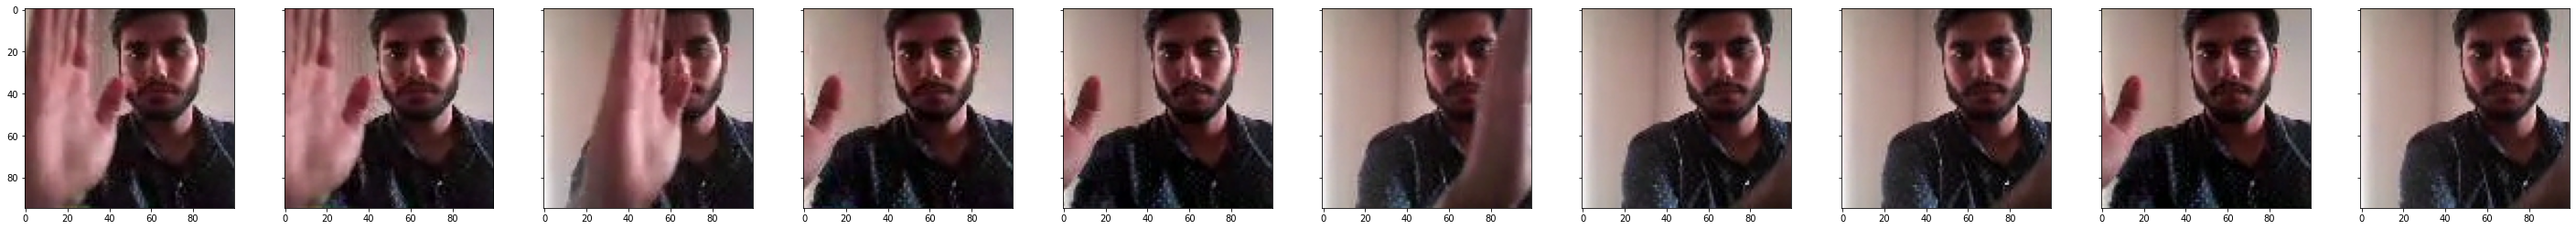

In [50]:
img = [crop(x, ((25,0), (30, 30), (0,0))) for x in imgs]
plot_image(img[0:10], cmap='gray')

In [51]:
def crop_image(image):
  return crop(image, ((10,0), (15, 15), (0,0)))

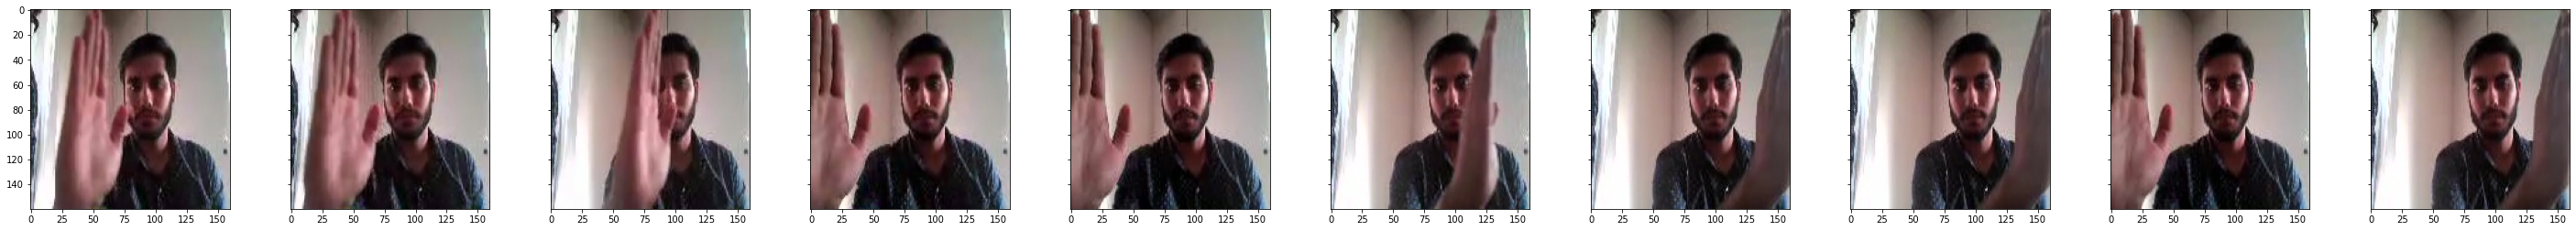

In [52]:
resized_imgs = []

for im in imgs:
  ij = resize(im, (160,160))
  resized_imgs.append(ij)
plot_image(resized_imgs[0:10])

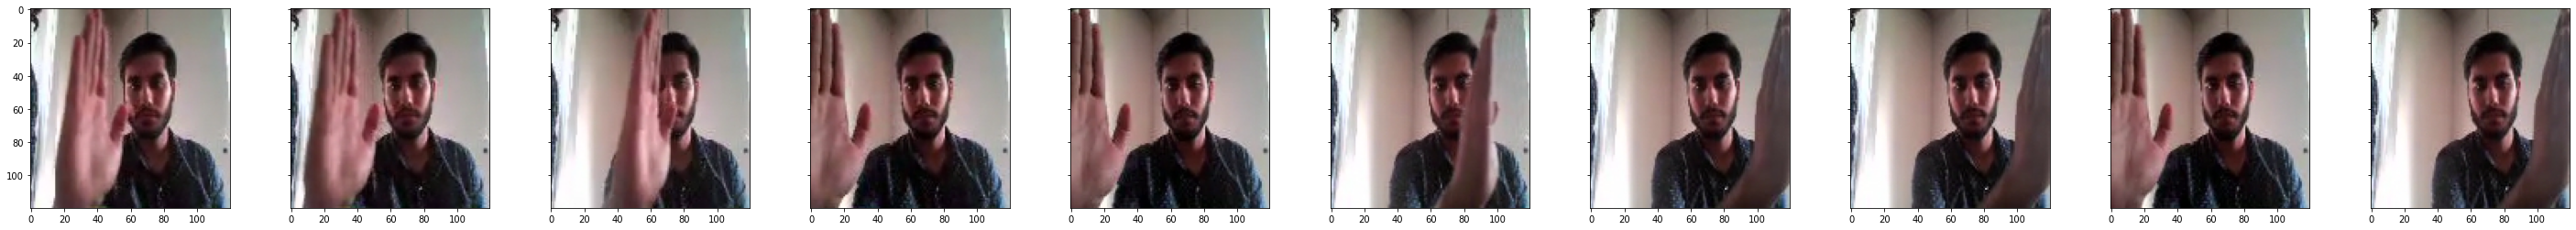

In [53]:

resized_imgs = []

for im in imgs:
  ij = resize(im, (120,120))
  resized_imgs.append(ij)
plot_image(resized_imgs[0:10])

We will maintain all image at same size of either 160x160 or 120x120. Preference will be the latter so that the image is not skewed.

### Normalization

We will test 3 different normalization and select one that is found most appropriate

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


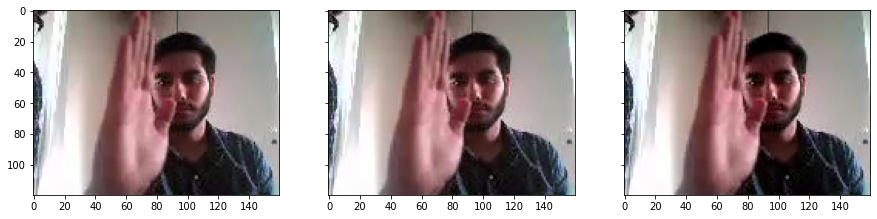

In [54]:
norm1_image = imgs[10]
norm2_image = (imgs[10] - np.min(imgs[10]))/(np.max(imgs[10]) - np.min(imgs[10]))
norm3_image = (imgs[10] - np.percentile(imgs[10],2))/ (np.percentile(imgs[10],98) - np.percentile(imgs[10],2))

plot_image([norm1_image, norm2_image, norm3_image], width=15)

We will use 2 perncetile and 98 percentile normalization. since it seem to produce an image with a sharper contrast.

In [55]:
def normalize_image(image):
  image = (image - np.percentile(image,2))/ (np.percentile(image,98) - np.percentile(image,2))
  return image

In this block, you read the folder names for training and validation. You also set the `batch_size` here. Note that you set the batch size in such a way that you are able to use the GPU in full capacity. You keep increasing the batch size until the machine throws an error.

In [56]:
batch_size = 100 #experiment with the batch size

IMG_SIZE_X = 80
IMG_SIZE_Y = 80
num_classes = 5
gru_cells = 15
img_idx = [x for x in range(0,30,2)] #create a list of image numbers you want to use for a particular video

## Generator
This is one of the most important part of the code. The overall structure of the generator has been given. In the generator, you are going to preprocess the images as you have images of 2 different dimensions as well as create a batch of video frames. You have to experiment with `img_idx`, `y`,`z` and normalization such that you get high accuracy.

In [57]:
time_steps = len(img_idx)
def generator(folder_list, batch_size):
    print( 'Source path = ', source_path, '; batch size =', batch_size)
    while True:    
      shuffled_folder_list = np.random.permutation(folder_list)
      num_batches = len(folder_list)//batch_size # calculate the number of batches
      for batch in range(num_batches): # we iterate over the number of batches
        yield process_batch(shuffled_folder_list, batch_size, batch)

      # write the code for the remaining data points which are left after full batches
      rem_batches = len(folder_list) % batch_size
      if rem_batches > 0:
          yield process_batch(shuffled_folder_list, rem_batches, num_batches)

def process_batch(shuffled_folder_list, batch_size, batch_num):
      batch_data = np.zeros((batch_size,time_steps,IMG_SIZE_X,IMG_SIZE_Y,3)) # x is the number of images you use for each video, (y,z) is the final size of the input images and 3 is the number of channels RGB
      batch_labels = np.zeros((batch_size,num_classes)) # batch_labels is the one hot representation of the output
      for folder in range(batch_size): # iterate over the batch_size
          folder_dir = shuffled_folder_list[folder + (batch_num*batch_size)].split(';')[0]
          imgs = os.listdir(folder_dir) # read all the images in the folder
          for idx,item in enumerate(img_idx): #  Iterate iver the frames/images of a folder to read them in
              image = imread(shuffled_folder_list[folder + (batch_num*batch_size)].strip().split(';')[0]+'/'+imgs[item]).astype(np.float32)
              
              #crop the images and resize them. Note that the images are of 2 different shape 
              #and the conv3D will throw error if the inputs in a batch have different shapes
              #Cropping and Resizing
              cropped = crop_image(image)
              resized = resize(cropped, (IMG_SIZE_X,IMG_SIZE_Y))
              batch_data[folder,idx,:,:,0] = normalize_image(resized[:,:,0]) #normalise and feed in the image
              batch_data[folder,idx,:,:,1] = normalize_image(resized[:,:,1]) #normalise and feed in the image
              batch_data[folder,idx,:,:,2] = normalize_image(resized[:,:,2]) #normalise and feed in the image
              
          batch_labels[folder, int(shuffled_folder_list[folder + (batch_num*batch_size)].strip().split(';')[2])] = 1
      return batch_data, batch_labels #you yield the batch_data and the batch_labels, remember what does yield do

Note here that a video is represented above in the generator as (number of images, height, width, number of channels). Take this into consideration while creating the model architecture.

In [58]:
curr_dt_time = datetime.datetime.now()
train_path = source_path + 'train'
val_path = source_path + 'val'
num_train_sequences = len(train_doc)
print('# training sequences =', num_train_sequences)
num_val_sequences = len(val_doc)
print('# validation sequences =', num_val_sequences)
num_epochs = 100 # choose the number of epochs
print ('# epochs =', num_epochs)

# training sequences = 663
# validation sequences = 100
# epochs = 100


## Model
Here you make the model using different functionalities that Keras provides. Remember to use `Conv3D` and `MaxPooling3D` and not `Conv2D` and `Maxpooling2D` for a 3D convolution model. You would want to use `TimeDistributed` while building a Conv2D + RNN model. Also remember that the last layer is the softmax. Design the network in such a way that the model is able to give good accuracy on the least number of parameters so that it can fit in the memory of the webcam.

In [59]:
from keras.models import Sequential, Model
from keras.layers import Dense, GRU, Flatten, TimeDistributed, Flatten, BatchNormalization, Activation, GlobalAveragePooling2D, MaxPool3D, Dropout
from keras.layers.convolutional import Conv3D, MaxPooling3D
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from keras import optimizers, layers
from tensorflow.keras.regularizers import l2

from keras import Input
from keras.models import Model, load_model
from keras.preprocessing import image
#from keras.applications.imagenet_utils import preprocess_input
from keras.initializers import glorot_uniform
from keras.preprocessing.image import ImageDataGenerator,load_img, img_to_array
from tensorflow.keras.applications.resnet50 import ResNet50

#write your model here

### CNN + RNN Architecture

We would employed a pretrained ResNet model and allow retraining of the last few layers of the model using our dataset.

After that we would pass the output from RNN into a GRU RNN model.

In [60]:
#create 3D CNN
def get_3d_cnn_model(width, height, depth):
    # """Build a 3D convolutional neural network model."""

    inputs = Input((width, height, depth,3))

    x = layers.Conv3D(filters=16, kernel_size=3, activation="relu")(inputs)
    x = layers.BatchNormalization()(x)
    x = layers.Conv3D(filters=32, kernel_size=3, activation="relu")(x)
    x = layers.MaxPool3D(pool_size=2)(x)
    x = layers.BatchNormalization()(x)
    x = layers.Dropout(0.2)(x)

    
    
    x = layers.Conv3D(filters=32, kernel_size=3, activation="relu")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Conv3D(filters=64, kernel_size=3, activation="relu")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Conv3D(filters=128, kernel_size=3, activation="relu")(x)
    x = layers.MaxPool3D(pool_size=2)(x)
    x = layers.BatchNormalization()(x)
    x = layers.Dropout(0.2)(x)

    
    x = layers.Conv3D(filters=256, kernel_size=3, activation="relu", padding='same')(x)
    x = layers.MaxPool3D(pool_size=2)(x)
    x = layers.BatchNormalization()(x)
    x = layers.Dropout(0.2)(x)

    x = layers.Dense(512, kernel_regularizer=glorot_uniform(0.01), activation="relu")(x)
    x = layers.GlobalAveragePooling3D()(x)
    x = layers.Dropout(0.4)(x)

    outputs = layers.Dense(units=num_classes, activation="softmax")(x)

    # Define the model.
    model = Model(inputs, outputs, name="3D_Convo")
    return model

    

In [61]:
# cnn_3d = get_3d_cnn_model(IMG_SIZE_X, IMG_SIZE_Y, time_steps)

# optimiser = 'adam' #write your optimizer
# cnn_3d.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
# print (cnn_3d.summary())

In [62]:
#create 3D CNN
def get_3d_cnn_padded_model(width, height, depth):
    # """Build a 3D convolutional neural network model."""

    inputs = Input((width, height, depth,3))

    x = layers.Conv3D(filters=16, kernel_size=3, activation="relu")(inputs)
    x = layers.BatchNormalization()(x)
    x = layers.Conv3D(filters=32, kernel_size=3, activation="relu", padding='same')(x)
    x = layers.MaxPool3D(pool_size=2)(x)
    x = layers.BatchNormalization()(x)
    x = layers.Dropout(0.2)(x)

    
    
    x = layers.Conv3D(filters=32, kernel_size=3, activation="relu")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Conv3D(filters=64, kernel_size=3, activation="relu")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Conv3D(filters=128, kernel_size=3, activation="relu", padding='same')(x)
    x = layers.MaxPool3D(pool_size=2)(x)
    x = layers.BatchNormalization()(x)
    x = layers.Dropout(0.2)(x)

    
    # x = layers.Conv3D(filters=256, kernel_size=3, activation="relu", padding='same')(x)
    # x = layers.MaxPool3D(pool_size=2)(x)
    # x = layers.BatchNormalization()(x)
    # x = layers.Dropout(0.2)(x)

    x = layers.Dense(512, kernel_regularizer=l2(0.01), activation="relu")(x)
    x = layers.GlobalAveragePooling3D()(x)
    x = layers.Dropout(0.5)(x)

    outputs = layers.Dense(units=num_classes, activation="softmax")(x)

    # Define the model.
    model = Model(inputs, outputs, name="3D_Convo")
    return model

    

In [63]:
cnn_3d_pad = get_3d_cnn_padded_model(IMG_SIZE_X, IMG_SIZE_Y, time_steps)

optimiser = 'adam' #write your optimizer
cnn_3d_pad.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print (cnn_3d_pad.summary())

Model: "3D_Convo"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_10 (InputLayer)       [(None, 80, 80, 15, 3)]   0         
                                                                 
 conv3d_5 (Conv3D)           (None, 78, 78, 13, 16)    1312      
                                                                 
 batch_normalization_5 (Batc  (None, 78, 78, 13, 16)   64        
 hNormalization)                                                 
                                                                 
 conv3d_6 (Conv3D)           (None, 78, 78, 13, 32)    13856     
                                                                 
 max_pooling3d_2 (MaxPooling  (None, 39, 39, 6, 32)    0         
 3D)                                                             
                                                                 
 batch_normalization_6 (Batc  (None, 39, 39, 6, 32)    128

### CNN_GRU Model

We will take a ResNet Pretrained model and fine tune the last 10 layers of it and then pass all the features to a GRU model that will be used to classify the videos.

In [64]:

# Create the CNN ResNet Model
def get_pretrained_model():
    # Get base model 
    # Here we are using ResNet50 as base model
    feature_extractor = ResNet50(weights='imagenet', include_top=False, pooling='avg', input_shape=(IMG_SIZE_X, IMG_SIZE_Y, 3))
    
    # As we are using ResNet model only for feature extraction and not adjusting the weights
    # we only train the last layers in base model and freeze all the rest.
    num_layers_to_train = 10
    feature_extractor.layers.pop()
    feature_extractor.layers.pop()
    for layer in feature_extractor.layers[:-num_layers_to_train]:
        layer.trainable = False
    for layer in feature_extractor.layers[-num_layers_to_train:]:
        layer.trainable = True
    
    # Get base model output 
    base_model_ouput = feature_extractor.output


    # sequential component on top of CNN
    frames = Input(shape=(time_steps, IMG_SIZE_X, IMG_SIZE_Y, 3))
    x = TimeDistributed(feature_extractor)(frames)
    x = TimeDistributed(Flatten())(x)
          
  
    # Create GRU model and pass feature as input form CNN into the RNN
    x = GRU(gru_cells, return_sequences=True, dropout=0.3)(x)
    x = Flatten()(x)
    x = Dense(512, activation='relu')(x)
    # x = Dropout(0.5)(x)
    out = Dense(num_classes, activation='softmax')(x)
    
    return Model(inputs=frames, outputs=out)

In [65]:
cnn_rnn = get_pretrained_model()

optimiser = 'adam' #write your optimizer
cnn_rnn.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print (cnn_rnn.summary())

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_12 (InputLayer)       [(None, 15, 80, 80, 3)]   0         
                                                                 
 time_distributed_8 (TimeDis  (None, 15, 2048)         23587712  
 tributed)                                                       
                                                                 
 time_distributed_9 (TimeDis  (None, 15, 2048)         0         
 tributed)                                                       
                                                                 
 gru_1 (GRU)                 (None, 15, 15)            92925     
                                                                 
 flatten_9 (Flatten)         (None, 225)               0         
                                                                 
 dense_12 (Dense)            (None, 512)               1157

### CNN_LSTM Model

We will not fine tune the model because we do not want to have too many parameters to train since LSTM generally is more difficult to train than GRU

In [66]:
from keras.layers.recurrent import LSTM
# Create the CNN ResNet Model + LSTM
def get_cnn_lstm():
    # Get base model 
    # Here we are using ResNet50 as base model
    feature_extractor = ResNet50(weights='imagenet', include_top=False, pooling='avg', input_shape=(IMG_SIZE_X, IMG_SIZE_Y, 3))
    
    # As we are using ResNet model only for feature extraction and not adjusting the weights
  
    num_layers_to_train = 10
    feature_extractor.layers.pop()
    feature_extractor.layers.pop()
    for layer in feature_extractor.layers:
        layer.trainable = False
  
    
    # Get base model output 
    base_model_ouput = feature_extractor.output


    # sequential component on top of CNN
    frames = Input(shape=(time_steps, IMG_SIZE_X, IMG_SIZE_Y, 3))
    x = TimeDistributed(feature_extractor)(frames)
    x = TimeDistributed(Flatten())(x)
          
  
    # Create GRU model and pass feature as input form CNN into the RNN
    x = LSTM(gru_cells, return_sequences=True, dropout=0.3)(x)
    x = Flatten()(x)
    x = Dense(512, activation='tanh')(x)
    # x = Dropout(0.5)(x)
    out = Dense(num_classes, activation='softmax')(x)
    
    return Model(inputs=frames, outputs=out, name='cnn_lstm')

Now that you have written the model, the next step is to `compile` the model. When you print the `summary` of the model, you'll see the total number of parameters you have to train.

In [67]:
cnn_lstm = get_cnn_lstm()

optimiser = 'adam' #write your optimizer
cnn_lstm.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print (cnn_lstm.summary())

Model: "cnn_lstm"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_14 (InputLayer)       [(None, 15, 80, 80, 3)]   0         
                                                                 
 time_distributed_10 (TimeDi  (None, 15, 2048)         23587712  
 stributed)                                                      
                                                                 
 time_distributed_11 (TimeDi  (None, 15, 2048)         0         
 stributed)                                                      
                                                                 
 lstm_3 (LSTM)               (None, 15, 15)            123840    
                                                                 
 flatten_11 (Flatten)        (None, 225)               0         
                                                                 
 dense_14 (Dense)            (None, 512)               115

Let us create the `train_generator` and the `val_generator` which will be used in `.fit_generator`.

Since we cannot do auguementation because of the sequence that needs to be maintained, we will try to add some more validation data from train data.

In [68]:
#val_doc = np.concatenate((val_doc , train_doc[600:]))
# val_doc = np.array(val_doc[:1])
val_generator = generator(val_doc, batch_size)
# train_doc = np.array(train_doc[:100])
train_generator = generator(train_doc, batch_size)

In [69]:
# sample_train_rand = np.random.permutation(train_doc)[:100]
# sample_val_rand = np.random.permutation(train_doc)[:22]

# train_generator = generator(train_path, sample_train_rand, batch_size, False)
# val_generator = generator(val_path, sample_val_rand, batch_size, False)

In [70]:
model_name = 'model_init' + '_' + str(curr_dt_time).replace(' ','').replace(':','_') + '/'
    
if not os.path.exists(model_name):
    os.mkdir(model_name)
        
filepath = model_name + 'model-{epoch:05d}-{loss:.5f}-{categorical_accuracy:.5f}-{val_loss:.5f}-{val_categorical_accuracy:.5f}.h5'

checkpoint = ModelCheckpoint(filepath, monitor='val_categorical_accuracy', verbose=1, save_best_only=True, save_weights_only=True, mode='max', save_freq='epoch')

LR = ReduceLROnPlateau(monitor='val_loss', factor=0.2,
                              patience=3, min_lr=0.001)  # write the code here
callbacks_list = [checkpoint, LR]

The `steps_per_epoch` and `validation_steps` are used by `fit_generator` to decide the number of next() calls it need to make.

In [71]:
num_train_sequences = len(train_doc)
num_val_sequences = len(val_doc)

if (num_train_sequences%batch_size) == 0:
    steps_per_epoch = int(num_train_sequences/batch_size)
else:
    steps_per_epoch = (num_train_sequences//batch_size) + 1

if (num_val_sequences%batch_size) == 0:
    validation_steps = int(num_val_sequences/batch_size)
else:
    validation_steps = (num_val_sequences//batch_size) + 1

print(steps_per_epoch)
print(validation_steps)

print(num_train_sequences)
print(num_val_sequences)

7
1
663
100


Let us now fit the model. This will start training the model and with the help of the checkpoints, you'll be able to save the model at the end of each epoch.

In [ ]:
cnn_lstm.fit(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=2, 
                    callbacks=callbacks_list, validation_data=val_generator, 
                    validation_steps=validation_steps, workers=1, initial_epoch=0)

Source path =  /content/dataDir/Project_data/ ; batch size = 100
Epoch 1/100
Source path =  /content/dataDir/Project_data/ ; batch size = 100

Epoch 1: val_categorical_accuracy improved from -inf to 0.23000, saving model to model_init_2022-07-1317_24_27.717249/model-00001-1.67129-0.20362-1.60515-0.23000.h5
7/7 - 161s - loss: 1.6713 - categorical_accuracy: 0.2036 - val_loss: 1.6051 - val_categorical_accuracy: 0.2300 - lr: 0.0010 - 161s/epoch - 23s/step
Epoch 2/100

Epoch 2: val_categorical_accuracy improved from 0.23000 to 0.34000, saving model to model_init_2022-07-1317_24_27.717249/model-00002-1.60955-0.23077-1.58804-0.34000.h5
7/7 - 145s - loss: 1.6095 - categorical_accuracy: 0.2308 - val_loss: 1.5880 - val_categorical_accuracy: 0.3400 - lr: 0.0010 - 145s/epoch - 21s/step
Epoch 3/100

Epoch 3: val_categorical_accuracy did not improve from 0.34000
7/7 - 143s - loss: 1.5867 - categorical_accuracy: 0.3002 - val_loss: 1.5707 - val_categorical_accuracy: 0.2600 - lr: 0.0010 - 143s/epoch - 